# Module 3: Dimensionality Reduction

Many machine learning problems involve thousands or even millions of features for each training instance. Not only do all these features make training extremely slow, but they can also make it much harder to find a good solution, as we will see. This problem is often referred to as the _curse of dimensionality_.

Fortunately, it is often possible to reduce the number of features considerably, which turns an intractable problem into a tractable one:

MNIST Feature Importances obtained through Random Forest Algorithm:
<img src="figures/MNISTFeatureImportances.png" width ="300" />

Image Compression performed via K-Means Algorithm:
<img src="figures/imageCompression.png" width ="500" />

In this module we will discuss the curse of dimensionality and get a sense of what goes on in high-dimensional space. Then, we will consider the two main approaches to dimensionality reduction (___projection___ and ___Manifold Learning___), and we will go through three of the most popular dimensionality reduction techniques: ___PCA___, ___KernelPCA___, and ___LLE___.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## The Curse of Dimensionality

High-dimensional spaces are hard to visualize!

<img src="figures/dimensions.png " width ="600" />

Many things behave very differently in high-dimensional space.  Here are a couple examples:

- For example, if you pick a random point in a unit square (a 1 × 1 square), it will have only about a 0.4% chance of being located less than 0.001 from a border. But in a 10,000-dimensional unit hypercube, this probability is greater than 99.999999%. Most points in a high-dimensional hypercube are very close to the border.

- If you pick two points randomly in a unit square, the distance between these two points will be, on average, roughly 0.52. If you pick two random points in a unit 3D cube, the average distance will be roughly 0.66. If you pick two points randomly in a 1,000,000-dimensional unit hypercube? The average distance will be about 408.25. Wow.

Let’s take a look at the two main approaches to reducing dimensionality: ___projection___ and ___Manifold Learning___.

# Projection Methods and Manifold Learning Overview

### Projection

In most real-world problems, training instances are not spread out uniformly across all dimensions. Many features are almost constant, while others are highly correlated. As a result, all training instances lie within (or close to) a much lower-dimensional ___subspace___ of the high-dimensional space.

Let's take a look at some data like this:

<img src="figures/dataset_3d_quick_view.png " width ="600" />

Notice that all training instances lie close to a plane: this is a lower-dimensional (2D) subspace of the high-dimensional (3D) space. If we project every training instance perpendicularly onto this subspace, then we get the new 2D dataset shown here:

<img src="figures/dimensions_2D.png " width ="300" />

### Manifold Learning

However, projection is not always the best approach to dimensionality reduction.  Consider the _Swiss roll_ toy dataset:

<img src="figures/swiss_roll.png " width ="500" />

Simply projecting this data onto a plane would squash different layers of the Swiss roll together, as shown on the left side of the following figure. What you really want is to unroll the Swiss roll to obtain the 2D dataset on the right side of the following figure.

<img src="figures/swiss_roll_proj.png " width ="800" />

The manifold assumption is often accompanied by another implicit assumption: that the task at hand (e.g., classification or regression) will be simpler if expressed in the lower-dimensional space of the manifold.  However, this implicit assumption does not always hold.

In short, reducing the dimensionality of your training set before training a model will
usually speed up training, but it may not always lead to a better or simpler solution; it
all depends on the dataset.

<img src="figures/swiss_roll_complex.png " width ="800" />

# PCA

___Principal Component Analysis (PCA)___ is by far the most popular dimensionality reduction algorithm. First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

Saving figure pca_best_projection_plot


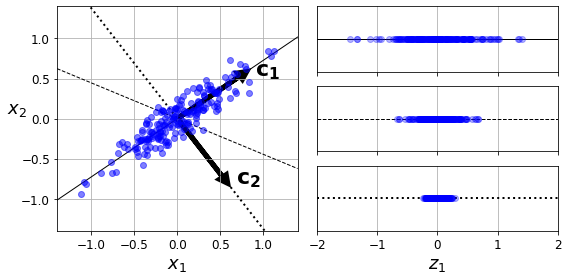

In [4]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m,2)/10
X = X.dot(np.array([[stretch, 0], [0,1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("pca_best_projection_plot")
plt.show()

## PCA using SVD Decomposition

PCA identifies the direction that accounts for the largest amount of variance in the training set. It also finds a second direction, that is orthogonal to the first one, that accounts for the largest amount of remaining variance. In this 2D example there is no choice: it is the dotted line. The ith direction/axis is called the ___$i^{th}$ principal component (PC)___ of the data.

Let's start by generating some data.  We are going to create the second figure shown in this notebook.

In [6]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

So how can you find the principal components of a training set? There is a standard matrix factorization technique called _Singular Value Decomposition (SVD)_ (you are not responsible for understanding SVD) that can decompose the training set feature matrix $X$ into the matrix multiplication of three matrices $X = U \Sigma V^T$, where $V$ contains the unit vectors that define all the principal components that we are looking for, as shown below:

<img src="figures/principal_components.png " width ="200" />

Although the book does not discuss eigenvectors and eigenvalues, PCA is actually an eigen-problem.  The principal components of the feature matrix $X$ are actually eigenvectors of the covariance matrix of $X$, and the eigenvalues indicate the amount of variance explained by its associated eigenvector.  You are not responsible for understanding eigenvalue problems.

Let's find the first two principal components of our data, and prove to ourselves that SVD works properly:

In [5]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [ ]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

The allclose() function returns `True` if two arrays are element-wise equal within a tolerance:

In [ ]:
np.allclose(X_centered, u.dot(S).dot(vt))

To project the training set onto the lower-dimensional hyperplane and obtain a reduced dataset of dimensionality $d$, compute the matrix multiplication of the training set matrix $X$ by the matrix $W_d$, defined as the matrix containing the first $d$ columns of $V$, as shown in the following equation:

<img src="figures/projection.png " width ="200" />

The following Python code projects the training set onto the plane defined by the first
two principal components:

In [ ]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [ ]:
X2D_using_svd = X2D

## PCA using Scikit-Learn

Let's learn how to fit a PCA transformer.  With Scikit-Learn, doing PCA is really trivial. It even takes care of mean centering for you:

In [ ]:
from sklearn.decompositionimport PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [ ]:
X2D[:5]

In [ ]:
X2D_using_SVD[:5]

Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped:

In [ ]:
np.allclose(X2D, -X2D_using_SVD)

What about the principal components? The `PCA` object gives access to the principal components that it computed through the `components_` attribute:

In [ ]:
pca.components_

Compare to the first two principal components computed using the SVD method:

In [ ]:
VT[:2]

Notice how the axes are flipped.

### Explained Variance Ratio

The ratio indicates the proportion of the dataset’s variance that lies along each principal component.

In [ ]:
pca.explained_variance_ratio_

As you can see above, the first PC explains 84.2% of the variance, while the second explains 14.6%.  By projecting down to 2 dimensions, we lost about 1.1% of the variance in the data, shown below:

In [ ]:
1 - pca.explained_variance_ratio_.sum()

Here is how to compute the explained variance ratio using the SVD approach (recall that `s` is the diagonal of the matrix `S`):

In [ ]:
np.square(s) / np.square(s).sum()

### Recovered Data

Can we recover the 3D data? Yes! To recover the 3D points projected on the plane (PCA 2D subspace), use the `inverse_transform` method:

In [ ]:
X3D_inv = pca.inverse_transform(X2D)

Of course, there was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points:

In [ ]:
np.allclose(X3D_inv, X)

We can compute the reconstruction error (which is the MSE):

In [ ]:
np.mean(np.sum(np.square(X3D_inv - X), axis = 1))

The inverse transform in the SVD approach looks like this:

In [ ]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

The reconstructions from both methods are not identical because Scikit-Learn's `PCA` class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction:

In [ ]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

Next, let's generate some nice figures.  Note that this utility class to draw 3D arrows was copied from [Stack Overflow](http://stackoverflow.com/questions/11140163).

In [ ]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

Express the plane as a function of x and y.

In [ ]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Plot the 3D dataset, the plane and the projections on that plane.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

save_fig("dataset_3d_plot")
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

# Manifold Learning

(This section merely recreates the figures we discussed above.) Let's revisit the figures we saw previously.  We will create those figures here.

In [ ]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [ ]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

In [ ]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

In [ ]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot2")
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot4")
plt.show()

# Choosing the Right Number of Dimensions and MNIST Compression

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is simpler to choose the number of dimensions that add up to a sufficiently large portion of the variance (i.e. 95%).

Let's start by importing the MNIST dataset.

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

The following code performs PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set’s variance:

In [ ]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [ ]:
d

You could then set n_components=d and run PCA again. But there is a much better option: instead of specifying the number of principal components you want to preserve, you can set n_components to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve:


In [ ]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)


In [ ]:
pca.n_componenents_

In [ ]:
np.sum(pca.explained_variance_ratio_)

Yet another option is to plot the explained variance as a function of the number of dimensions:

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

It is also possible to decompress the reduced dataset by applying the inverse transformation of the PCA projection. This won’t give you back the exact original data, but it will be close. The mean squared distance between the original data and the reconstructed data (compressed and then decompressed) is called the ___reconstruction error___.

The following code compresses the MNIST dataset down to 154 dimensions, then uses the inverse_transform() method to decompress it back to 784 dimensions:

In [ ]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [ ]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [ ]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

In [ ]:
X_reduced_pca = X_reduced

The equation of the inverse transformation is:

$$ \mathbf{X}_{recovered} = \mathbf{X}_{d\_proj}\mathbf{W}_{d}^{T} $$

## Randomized PCA

If you set the svd_solver hyperparameter to "randomized", Scikit-Learn uses a stochastic algorithm called ___Randomized PCA___ that quickly finds an approximation of the first d principal components.

The computational complexity of randomized PCA is $O(m \cdot d^2) + O(d^3)$, whereas full SVD PCA is $O(m \cdot n^2) + O(n^3)$.  So, randomized PCA is dramatically faster than full SVD when d is much smaller than n.


In [ ]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

## Incremental PCA 

One problem with the PCA implementations we have discussed so far is that they require the whole training set to fit in memory in order for the algorithm to run. Fortunately, ___Incremental PCA (IPCA)___ algorithms allow you to split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time.


In [ ]:
from sklearn.decompositionimport IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="")
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [ ]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

In [ ]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [ ]:
X_reduced_inc_pca = X_reduced

Let's compare the results of transforming MNIST using regular PCA and incremental PCA. First, the means are equal: 

In [ ]:
np.allclose(pca.mean_, inc_pca.mean_)

But the results are not exactly identical. Incremental PCA gives a very good approximate solution, but it's not perfect:

In [ ]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

## Time Complexity

Let's time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:

In [ ]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca =PCA(n_components = n_components)
    inc_pca = IncrementalPCA(n_components = n_components, batch_siz(e = 500)
    rnd_pca PCA(n_components = n_components, svd_solver="radnomized", random_state=42)

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

# Kernel PCA

Last semester when studying SVMs, we discussed the kernel trick, which is a mathematical technique that implicitly maps instances into a very high-dimensional space (called the feature space) and enables nonlinear classification and regression. Recall that a linear decision boundary in the high-dimensional feature space corresponds to a complex nonlinear decision boundary in the original space.

It turns out that the same trick can be applied to PCA, making it possible to perform complex nonlinear projections for dimensionality reduction. This is called ___Kernel PCA (kPCA)___. 

In [ ]:
from sklearn.datasets import make_swiss_roll
X,t = make_swiss_roll(n_samples = 1000, noise = 0.2, random_state = 42)

In [ ]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)


In [ ]:
from sklearn.decomposition import KernelPCA

lin_pca =  KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform =True, gamma=0.04)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform =True)
sig_pca =  KernelPCA(n_components = 2, kernel="sigmoid", fit_inverse_transform =True, coefo=0)


y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
("kpca", KernelPCA(n_components=2)),
("log_reg", LogisticRegression())
])
param_grid = [{
"kpca__gamma": np.linspace(0.03, 0.05, 10),
"kpca__kernel": ["rbf", "sigmoid"]
}]
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

In [ ]:
print(grid_search.best_params_)

# LLE

___Locally Linear Embedding (LLE)___ is another powerful ___nonlinear dimensionality reduction (NLDR)___ technique. It is a manifold learning technique that does not rely on projections, like the previous algorithms do. In a nutshell, LLE works by first measuring how each training instance linearly relates to its closest neighbors, and then looking for a low-dimensional representation of the training set where these local relationships are best preserved. 

In [ ]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

The following code uses Scikit-Learn’s LocallyLinearEmbedding class to unroll the Swiss roll:

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)


In [ ]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

# MDS, Isomap and t-SNE

Other dimensionality reduction techniques include:

- Multidimensional Scaling (MDS)
- Isomap
- t-Distributed Stochastic Neighbor Embedding (t-SNE)
- Linear Discriminant Analysis (LDA)
- Random Projections

A few of examples of these methods are shown below:

In [ ]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [ ]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

In [ ]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()